##### Notes on a framework for Simulation Engine


 - Conceptual hierarchies involved in the Simulation engine

| spatial  | Temporal |
-----------|--------------
|Studies entities based with respect to geometric / topological / etc..(see work by Klaus) |Dynamics and evolution with respect to time|
|Spatial Statistics/ Cellular Automata/ Multi Agent Systems|Discrete / Continuous / Hybrid / State space models|


 - Initially, I consider primarily Temporal Dynamic systems considering interactions between variables as described by a causal graph
 
 - Kind of problems I am looking at
 
 
 
 
 - The relationships between variables shall be encoded by a directed graph (or possibly be a tree) with following node and edge attributes (note that edge attributes and edge flows are interchangeable in the context of this work)
     
     - Node attributes are the function describing how to transform the values transported by all incoming edge attributes
     
     - Edge attributes are the transformations of parent node values 
     
     
 - The origin node (aka "root") denotes the exogeneous node
 
 - At each time step, propagate computations down from exogeneous nodes

##### Data structure for simulation engine. 

Model the relationship between variables as an attributed graph, with the following attributes
 - Node attribute with dictionary keys 
     - function, which describes a transformation to be applied on to incoming flow varaibles
     - value, which describes the value of computation
     
 - Edge attribute with dictionary keys
     - function, which describes a transformation on edge flow variables


In [1]:
class DynamicalSimulator:
    
    def __init__(self,flow_graph = None):
        '''
        what sort of graphs do we want to allow. Ideally Digraphs with node and edge with
        2 classes of attributes, funtion and value
        '''
        self.sim_graph = flow_graph
        self.clock = 0
        self.node_values ={}
        for _node in self.sim_graph.nodes:
            self.node_values[_node] = []
        
    
    def fit_params(self,node_values = []): 
        '''
        For the cases, where the edge attributes indicate dynamical relationships, solve the 
        dynamical system. Else, use fit()
        '''
        pass
    
    def reset_flows(self):
        '''
        reset all edge flows / attributes to be None
        '''
        pass
    
    def clock_tick(self,**kwargs): 
        '''
        Do the bookkeeping ops with the clock tick.
        '''
        self.reset_flows()
        self.clock += 1
        #print('Tick tock %d'%(self.clock))
        self.propagate_influences()
        
    
    
    def propagate_influences(self):
        '''
        - At the next tick, apply the functional relationship of the node on the incoming edge values
        - set the edge values of all outgoing edges to be the node computation
        '''
        #print('Propagating vals')
        # Topologically sort the graph
        sorted_nodes = list(nx.algorithms.dag.topological_sort(self.sim_graph))
        
        for _node in sorted_nodes:       
            # Nothing to be done for root nodes
            if len(list(self.sim_graph.in_edges(_node))) == 0:
                #print('Root node %s' %(_node))
                pass
            #  compute node attribute transformation of incoming edge flows / attributes
            else:
                edge_vals = []
                for _edge in list(self.sim_graph.in_edges(_node)):
                    _edge_fn = nx.get_edge_attributes(self.sim_graph,'fn')[_edge]
                    _parent_node_val =nx.get_node_attributes(self.sim_graph,'val')[_edge[0]]
                    edge_vals.append(_edge_fn(_parent_node_val))
                #print(edge_vals)
                # Compute the new node values after collecting edge values
                node_value = nx.get_node_attributes(self.sim_graph,'fn')[_node](*edge_vals)
                self.sim_graph.nodes[_node]['val'] = node_value
                self.node_values[_node].append(node_value)
                
    def discrete_simulator(self,t_end,exogenous_node_vals = {}):
        #nx.set_node_attributes(self.sim_graph,exogenous_node_vals)
        for t_step in range(t_end):
            #print(t_step)
            for _node in list(exogenous_node_vals.keys()):
                #print(_node)
                self.sim_graph.nodes[_node]['val'] = exogenous_node_vals[_node][t_step]
            self.clock_tick()
            #self.sim_graph[]
            
        
        
            
                
        
    
        
    
    
    
    
        

Construct a simple graph, 2 exogeneous nodes and 3 endogeneous nodes. Just a thought model, One exogeneous node denotes the #infections and another some sort of cyclical signal (say recurrent lockdown). The endogneous nodes denote the system responses.

In [20]:
# Define a simple Simulation graph. Propagate values for 100 time steps or so. 

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
%matplotlib inline


def run_graph(exp_coeff=-0.001,product_fn_coeff=2*np.pi):
    sim_graph = nx.DiGraph([(1,2),(2,4),(3,4),(2,5),(4,5)])
    nx.set_edge_attributes(sim_graph,{(1,2):{'fn':lambda x: x},
                                      (2,4):{'fn':lambda x: 2*x},
                                      (3,4):{'fn':lambda x: np.sin(x)},
                                      (2,5):{'fn':lambda x: x**2},
                                      (4,5): {'fn':lambda x: x}})

    
    def logistic(x):
        return 1/(1+np.exp(-0.01*x))

    def exp_fn(x):
        return np.exp(exp_coeff*x)

    def product_fn(x,y):
        return np.exp(-abs(x-y)**0.5)*y/(product_fn_coeff)
    
    def identity(x):
        return x
    
    def noisy_identity(x):
        return x + x*np.random.random()
    
    
    time_vals = np.array(range(100))
    infec_vals = list(map(logistic,time_vals))


    nx.set_node_attributes(sim_graph,{1:{'fn':identity,'val':None},
                                      2:{'fn': exp_fn,'val':None},
                                      3:{'fn':noisy_identity,'val':None},
                                      4:{'fn': product_fn, 'val':None},
                                      5:{'fn':product_ n,'val':None}})

    pos = nx.layout.spring_layout(sim_graph) 
    nx.draw_networkx(sim_graph,pos)
    plt.show()
    #nx.draw_networkx_labels(sim_graph,pos)

    simulator = DynamicalSimulator(sim_graph)
    simulator.discrete_simulator(t_end=100,exogenous_node_vals={1:infec_vals,3:np.sin(2*np.pi*0.1*time_vals)})
    out_vals = np.array([np.array(simulator.node_values[2]),np.array(simulator.node_values[3])])
    return (out_vals),simulator

Run the graph and plot the results

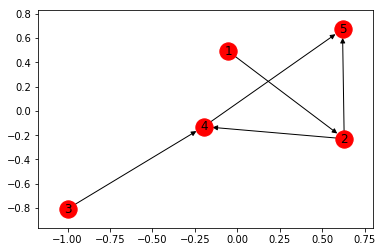

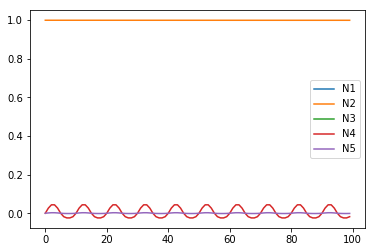

In [21]:
out_2,simulator = run_graph()
plt.plot(simulator.node_values[1])
plt.plot(simulator.node_values[2])
plt.plot(simulator.node_values[3])
#simulator.node_values
plt.plot(simulator.node_values[4])
plt.plot(simulator.node_values[5])
#plt.plot(np.array(list(range(100)))/100)
plt.legend(['N1','N2','N3','N4','N5'])

A simple integration tril with EMA workbench

In [22]:
try:
    from ema_workbench import RealParameter, ScalarOutcome, Constant,Model, ArrayOutcome
    from ema_workbench import MultiprocessingEvaluator, ema_logging,perform_experiments
    ema_logging.log_to_stderr(ema_logging.INFO)

except ModuleNotFoundError:
    !pip install ema_workbench
    from ema_workbench import RealParameter, ScalarOutcome, Constant,Model, ArrayOutcome
    from ema_workbench import MultiprocessingEvaluator, ema_logging,perform_experiments
    ema_logging.log_to_stderr(ema_logging.INFO)
    


In [23]:
model = Model('simengine', function=run_graph)
model.uncertainties = [RealParameter('exp_coeff', -10, 10)
                       ]

model.levers = [RealParameter('product_fn_coeff', -2*np.pi, 2*np.pi)
                       ]

model.outcomes = [ArrayOutcome('out_vals')]


with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=50, policies=4)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 50 scenarios * 4 policies * 1 model(s) = 200 experiments
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 140 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [24]:
expers, outcomes = results

In [ ]:
import pandas as pd
plt.hist(outcomes['out_vals'][0,:][0])
plt.figure()
plt.hist(outcomes['out_vals'][1,:][0])
plt.title('Distribution of Node 2 for scenario models')

Text(0.5, 1.0, 'Distribution of Node 2 for scenario models')

In [38]:
outcomes['out_vals'][1,:]

array([array([0.08672844, 0.08567466, 0.08463373, 0.08360556, 0.08259002,
       0.08158702, 0.08059645, 0.0796182 , 0.07865216, 0.07769821,
       0.07675626, 0.07582619, 0.07490789, 0.07400125, 0.07310616,
       0.07222252, 0.0713502 , 0.07048911, 0.06963912, 0.06880013,
       0.06797203, 0.0671547 , 0.06634804, 0.06555194, 0.06476629,
       0.06399097, 0.06322589, 0.06247092, 0.06172595, 0.06099089,
       0.06026563, 0.05955004, 0.05884403, 0.0581475 , 0.05746032,
       0.0567824 , 0.05611364, 0.05545391, 0.05480313, 0.05416119,
       0.05352798, 0.05290339, 0.05228734, 0.05167971, 0.0510804 ,
       0.05048932, 0.04990636, 0.04933143, 0.04876442, 0.04820524,
       0.04765379, 0.04710998, 0.0465737 , 0.04604487, 0.04552338,
       0.04500916, 0.04450209, 0.0440021 , 0.04350908, 0.04302296,
       0.04254363, 0.04207102, 0.04160503, 0.04114558, 0.04069257,
       0.04024594, 0.03980558, 0.03937141, 0.03894336, 0.03852134,
       0.03810527, 0.03769507, 0.03729065, 0.03689195, 